## Final Project

### Prepare Environment

Install libraries and load modules

In [1]:
!pip install python-chess==1.2.0

     |████████████████████████████████| 140 kB 39.0 MB/s 
  Attempting uninstall: python-chess
    Found existing installation: python-chess 0.23.11
    Uninstalling python-chess-0.23.11:
      Successfully uninstalled python-chess-0.23.11


In [2]:
# use ray which is 10x faster than the multiprocessing libary in python
!pip install -U ray

     |████████████████████████████████| 54.7 MB 21 kB/s 
     |████████████████████████████████| 118 kB 58.5 MB/s 


In [3]:
!wget https://stockfishchess.org/files/stockfish_14.1_linux_x64.zip
!unzip -o stockfish_14.1_linux_x64.zip
!chmod +x stockfish_14.1_linux_x64/stockfish_14.1_linux_x64

--2021-11-16 18:45:02--  https://stockfishchess.org/files/stockfish_14.1_linux_x64.zip
Resolving stockfishchess.org (stockfishchess.org)... 104.25.158.9, 104.25.159.9, 172.67.80.249, ...
Connecting to stockfishchess.org (stockfishchess.org)|104.25.158.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28788691 (27M) [application/zip]
Saving to: ‘stockfish_14.1_linux_x64.zip’

stockfish_14.1_linu 100%[===================>]  27.45M  10.4MB/s    in 2.6s    

2021-11-16 18:45:05 (10.4 MB/s) - ‘stockfish_14.1_linux_x64.zip’ saved [28788691/28788691]

Archive:  stockfish_14.1_linux_x64.zip
  inflating: stockfish_14.1_linux_x64/AUTHORS  
  inflating: stockfish_14.1_linux_x64/Copying.txt  
  inflating: stockfish_14.1_linux_x64/info.txt  
  inflating: stockfish_14.1_linux_x64/stockfish_14.1_linux_x64  
   creating: stockfish_14.1_linux_x64/stockfish_14.1_src/
   creating: stockfish_14.1_linux_x64/stockfish_14.1_src/.github/
   creating: stockfish_14.1_linux_x64/stockfis

In [4]:
import chess
import chess.pgn
import chess.engine

import psutil
import ray
from ray.util.multiprocessing import Pool

import numpy as np
import math
import random
from datetime import date
import time
from IPython.display import display

/usr/local/lib/python3.7/dist-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [5]:
# increase limits for multiprocessing
import sys
sys.setrecursionlimit(10000)

if ray.is_initialized():
  ray.shutdown()
ray.init()
pool = Pool()

### Class: Node

The class node is used to build trees for use in a monte carlo tree search

In [6]:
class node():
  def __init__(self):
    self.state = chess.Board()
    self.action = ''
    self.children = set()
    self.parent = None
    self.N = 0
    self.n = 0
    self.v = 0

choices = []

def reset_choices():
  global choices
  choices = []

### Class: ActionSpace

The ActionSpace class is used to interprete current state of a game

In [7]:
class ActionSpace():
  def __init__(self, board):
    self.board = board

  def sample(self) -> str:
    """
    Returns a random legal move as a string in algebraic notation
    :return: move as a string
    """
    return random.choice(self.available_actions())

    def available_actions(self) -> list[str]:
      """
      Returns a list of legal moves as a list of strings where the moves
      are in algebraic notation
      :return: list of moves
      """
      legal_moves = list(self.board.legal_moves)
      legal_moves_str = [str(move) for move in legal_moves]
      return legal_moves_str

### Class: ChessEnv

Configures a chess environment for use in a game

In [8]:
class ChessEnv():
  """
  Chess Environment. Player is always white. Opponent is black
  """

  def __init__(self, opponent):
    self.opponent = opponent
    self.board = chess.Board()
    self.game = chess.pgn.Game()
    self.game.headers['White'] = 'Player'
    self.game.headers['Black'] = self.opponent.name
    self.game.headers['Date'] = str(date.today())
    self.node = self.game
    self.action_space = ActionSpace(self.board)

  def _observation(self) -> str:
    """
    Returns the state of the game in Forsyth-Edwards Notation (FEN)
    :return: observation
    """
    return self.board.fen()

  def _is_done(self) -> bool:
    """
    :return: Return True if the game is over, else False
    """
    return self.board.is_game_over()

  def _reward(self) -> int:
    """
    Returns a reward from white's perspective
    Game not over = 0
    Win = +1
    Loss = -1
    Draw = 0
    :return: reward
    """
    if not self._is_done():
      reward = 0
    else:
      result = self.board.result()
      if result == '1-0':
        reward = 1
      elif result == '0-1':
        reward = -1
      elif result == '1/2-1/2':
        reward = 0
      else:
        raise Exception('Unknown end game state')
    return reward

  def reset(self) -> str:
    """
    Resets the game and returns an observation
    :return: observaction
    """
    self.board = chess.Board()
    self.game = chess.pgn.Game()
    self.game.headers['White'] = 'Player'
    self.game.headers['Black'] = self.opponent.name
    self.game.headers['Date'] = str(date.today())
    self.node = self.game
    return self._observation

  def render_image(self, **kwargs):
    return chess.svg.board(self.board, **kwargs)

  def render_txt(self):
    print('\n')
    print(self.board)
    print('\n')

  def render_image_jupyter(self):
    display(self.board)

  def step(self, action: str):
    """
    :param action: action in san
    """
    self.board.push_san(action)

### Class: MCTSAgent()

Create an agent that uses monte carlo tree search to determine a move

In [9]:
class MCTSAgent():
  def __init__(self, name: str, is_white: bool, multithreading=True):
    self.name = name
    self.is_white = is_white
    self.multithreading = multithreading
    print('Created Agent ''{}'' as {}; multithreading: {}'.\
          format(name, 'White' if is_white else 'Black', multithreading))

  def expand(self, current_node):
    """
    Expanding is used to increase the options further in the game by expanding
    the selected node and creating many children nodes
    :param current_node: node to expand, is_white: white or black player
    :return: the current node with the expanded children
    """
    if len(current_node.children) == 0:
      return current_node
    expanded_child = self.mcts_identify_best_ucb(current_node, self.is_white, True)
    return self.expand(expanded_child)

  def rollout(self, current_node):
    """
    Run a simulated rollout from M until a terminal state is found. The terminal state 
    contains a result (value) that will be returned to upwards in the is 
    backpropagation phase
    params: current_node: node to simulate
    return: the terminal state
    """
    if current_node.state.is_game_over():
      board = current_node.state
      if board.result() == '1-0':
        return 1, current_node
      elif board.result() == '0-1':
        return -1, current_node
      else:
        return 0.5, current_node
    
    all_moves = [current_node.state.san(i) for i in list(current_node.state.legal_moves)]

    for move in all_moves:
      tmp_state = chess.Board(current_node.state.fen())
      tmp_state.push_san(move)
      child = node()
      child.state = tmp_state
      child.parent = current_node
      current_node.children.add(child)
    
    random_state = random.choice(list(current_node.children))

    return self.rollout(random_state)

  def rollback(self, current_node, reward):
    """
    After the simulation phase, a result is returned. All nodes from M up to R 
    will be updated by adding the result to their value and increase the count of visits at each node
    params: current_node: the node with all children, reward: the reward to roll backpropagate
    returns: current_node with updated rewards
    """
    current_node.n += 1
    current_node.v += reward
    while(current_node.parent != None):
      current_node.N += 1
      current_node = current_node.parent
    return current_node

  def mcts_parallel_operation(self, item):
    """
    Performs a multiprocess exeuction to obtain the upper control bound of a given node
    params: i: process, child: node, idx: object reference id for node
    returns: tupple of idx, child, ucb
    """
    # Calculate the upper confidence bounds (UCB)
    child = item[0]
    idx = item[1]
    ucb = child.v + 2 * (math.sqrt(math.log(child.N + math.e + (10**-6)) / (child.n + (10**-10))))
    result = (idx, ucb)
    return result

  def mcts_identify_best_ucb(self, current_node, is_white, flip = False):
    """
    Determines the upper confidence bounds of each child in a given node
    params: current_node: the node, is_white: white or black player
    returns: sel_child: the child with the best upper confidence bounds
    """
    # create children to calculate UCB
    ref_child = {}
    pool_members = []
    idx = 0

    # build pool members to parallelize
    for child in current_node.children:
      ref_child[idx] = child
      pool_members.append((child, idx))
      idx+=1

    if self.multithreading:
      # run parallel collection of UCB across al node children
      global pool
      mcts_list = pool.map(self.mcts_parallel_operation, pool_members, chunksize=1000000)
    else:
      mcts_list = map(self.mcts_parallel_operation, pool_members)
    mcts_list = list(mcts_list)

    if flip:
      _param = 0 if is_white else 1
    else:
      _param = is_white

    if _param:
      max_idx = np.argmax(np.array(mcts_list)[:,1])
      max_idx = np.array(mcts_list)[max_idx,0]
      sel_child = ref_child[max_idx]
    else:
      min_idx = np.argmin(np.array(mcts_list)[:,1])
      min_idx = np.array(mcts_list)[min_idx,0]
      sel_child = ref_child[min_idx]

    mcts_list.clear()
    return sel_child

  # Monte Carlo Tree Search
  def observe(self, current_node, is_over=False, iterations=10):
    """
    Performs a monte carlo tree search on a given node
    params: the node to perform a MCTS
    returns: selected_move: the best move
    """
    if is_over:
      return -1
    root = node()
    root.state = current_node
    current_node = root

    all_moves = [current_node.state.san(i) for i in list(current_node.state.legal_moves)]
    map_state_move = dict()

    for move in all_moves:
      tmp_state = chess.Board(current_node.state.fen())
      tmp_state.push_san(move)
      child = node()
      child.state = tmp_state
      child.parent = current_node
      current_node.children.add(child)
      map_state_move[child] = move

    while(iterations > 0):
      sel_child = self.mcts_identify_best_ucb(current_node, self.is_white)
      ex_child = self.expand(sel_child)
      reward, state = self.rollout(ex_child)
      current_node = self.rollback(state, reward)

      iterations -= 1

    selected_move = ''
    sel_child = self.mcts_identify_best_ucb(current_node, self.is_white)
    selected_move = map_state_move[sel_child]
    
    return selected_move

### Class: StockfishAgent()

Create an agent that uses the stockfish engine

In [10]:
class StockfishAgent():
  def __init__(self, name: str, is_white: bool):
    self.name = name
    self.is_white = is_white
    self.engine = chess.engine.SimpleEngine.popen_uci('stockfish_14.1_linux_x64/stockfish_14.1_linux_x64')

    print('Created Agent ''{}'' as {}; Using Stockfish engine'.\
          format(name, 'White' if is_white else 'Black'))
    
  def observe(self, state):
    board = state
    result = self.engine.play(board, chess.engine.Limit(time=1))
    selected_move = str(result.move)
    return selected_move

In [11]:
def play_game(player, opponent):
  # Create environment
  env = ChessEnv(opponent=opponent)

  # Play Game
  ## Starts with player
  is_white = 1
  total_game_time = 0

  while not env._is_done():
    # set up base variables
    #root = node()
    #root.state = env.board
    state = env.board
    action = None
    current_player = player if is_white else env.opponent

    # observe action to take
    start = time.time()
    if is_white:
      action = player.observe(state)
    else:
      action = env.opponent.observe(state)
    end = time.time()
    duration = end - start
    total_game_time += duration
    # perform action
    env.step(action)
    print('{} Moved: {}, time taken to move: {:.2f}s'.format(current_player.name, action, duration))
    

    if not is_white:
      env.render_image_jupyter()
    is_white ^= 1

  return env, total_game_time

Created Agent Player as White; multithreading: False
============================== Starting Episode: 1 ==============================
Created Agent Stockfish Agent as Black; Using Stockfish engine
Player Moved: h4, time taken to move: 23.26s
Stockfish Agent Moved: e7e5, time taken to move: 1.01s


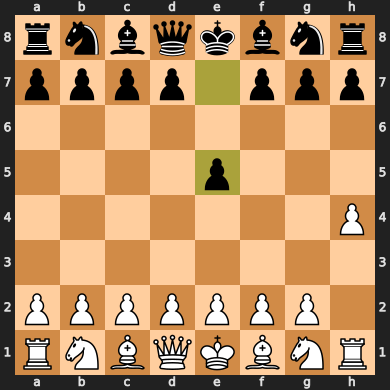

Player Moved: d4, time taken to move: 23.23s
Stockfish Agent Moved: e5d4, time taken to move: 1.00s


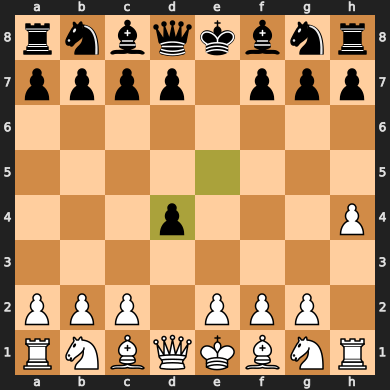

Player Moved: Bf4, time taken to move: 26.22s
Stockfish Agent Moved: f8b4, time taken to move: 1.00s


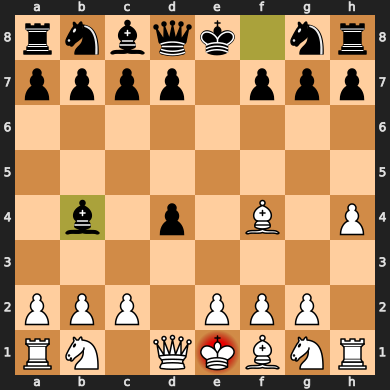

Player Moved: c3, time taken to move: 23.13s
Stockfish Agent Moved: d4c3, time taken to move: 1.00s


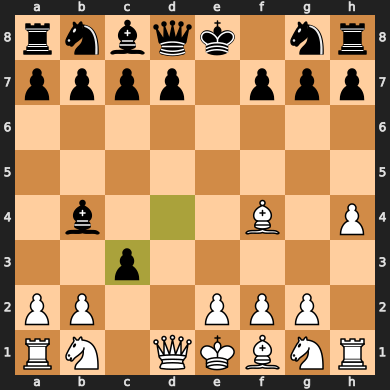

Player Moved: Qd2, time taken to move: 20.19s
Stockfish Agent Moved: c3b2, time taken to move: 1.00s


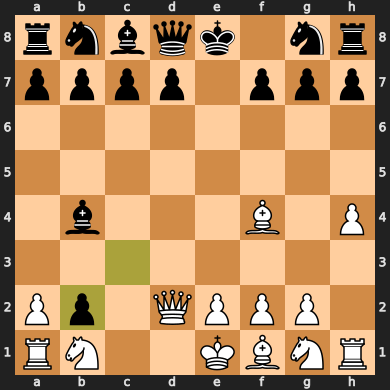

Player Moved: Rh3, time taken to move: 21.85s
Stockfish Agent Moved: b4d2, time taken to move: 1.00s


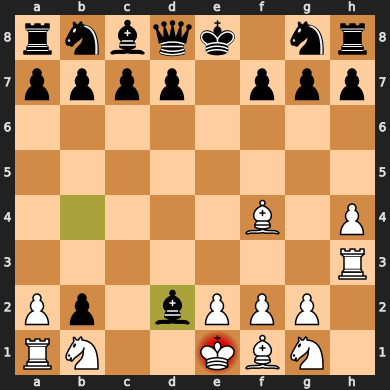

Player Moved: Kxd2, time taken to move: 16.83s
Stockfish Agent Moved: b2a1q, time taken to move: 1.00s


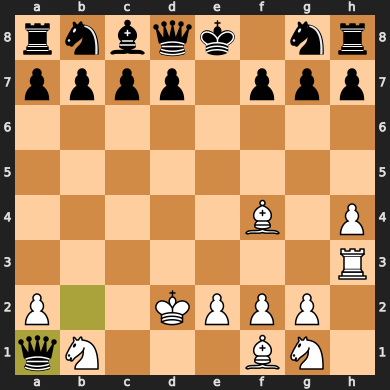

Player Moved: Rd3, time taken to move: 16.89s
Stockfish Agent Moved: a1b1, time taken to move: 1.00s


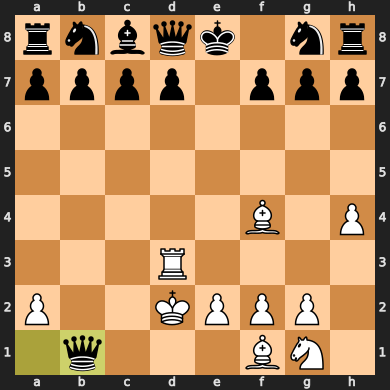

Player Moved: Rf3, time taken to move: 18.83s
Stockfish Agent Moved: b1f1, time taken to move: 1.00s


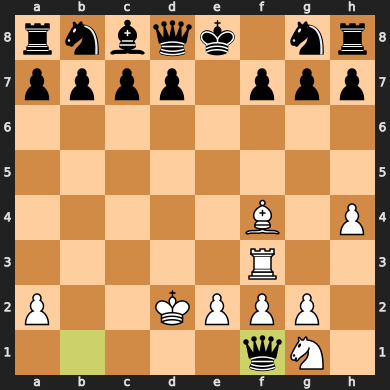

Player Moved: a3, time taken to move: 20.15s
Stockfish Agent Moved: f1g1, time taken to move: 1.00s


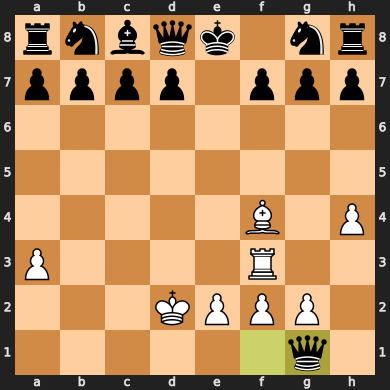

Player Moved: Rg3, time taken to move: 17.71s
Stockfish Agent Moved: d8h4, time taken to move: 1.00s


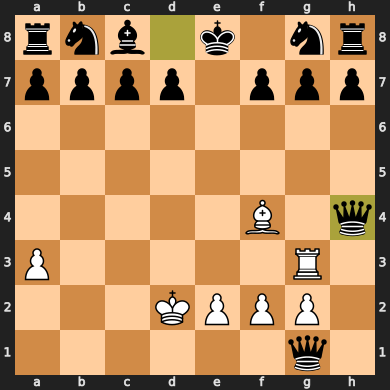

Player Moved: Rb3, time taken to move: 14.02s
Stockfish Agent Moved: h4f4, time taken to move: 1.00s


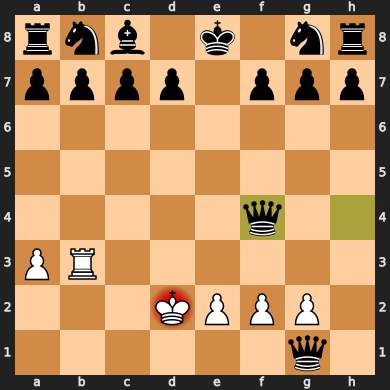

Player Moved: Kc3, time taken to move: 13.76s
Stockfish Agent Moved: g1c1, time taken to move: 0.01s


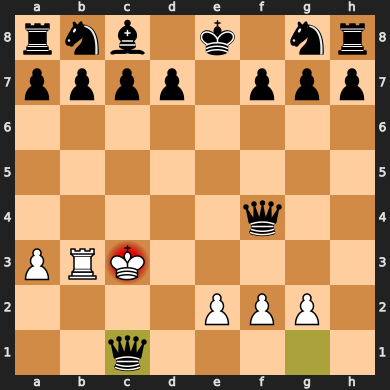

Player Moved: Kd3, time taken to move: 4.82s
Stockfish Agent Moved: f4c4, time taken to move: 0.01s


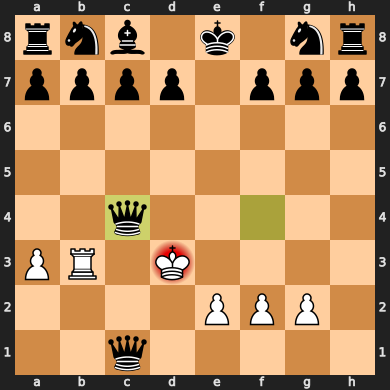

Total Game Time: 272.93019700050354s

Final Board:


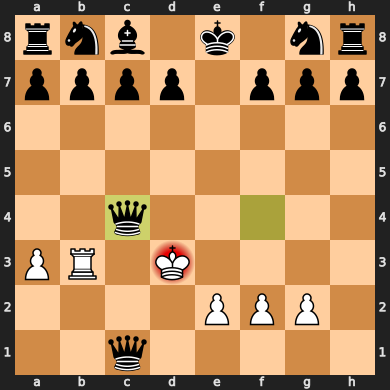


(Black) Stockfish Agent - Won the Game


In [12]:
# Create opponent
#opponent = MCTSAgent(name='MCTS Based Agent', is_white=False, multithreading=False)
player = MCTSAgent(name='Player', is_white=True, multithreading=False)

games = 1
episode = 0

while episode < games:
  print('='*30 + ' Starting Episode: {} '.format(episode+1) + '='*30)
  opponent = StockfishAgent(name='Stockfish Agent', is_white=False)
  env, total_game_time = play_game(player, opponent)

  print('Total Game Time: {}s'.format(total_game_time))
  print('')
  print('Final Board:')
  env.render_image_jupyter()
  print('')

  reward = env._reward()

  if reward == 1:
    print('(White) {} - Won the Game'.format(player.name))
  elif reward == -1:
    print('(Black) {} - Won the Game'.format(env.opponent.name))
  else:
    print('Game was a Draw between {} vs. {}'.format(player.name, env.opponent.name))

  episode += 1